## Setup

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import string
import unicodedata
# try to load the json data
import json
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from random import choice, choices, shuffle, randint

import matplotlib.pyplot as plt

assert torch.cuda.is_available()

     |████████████████████████████████| 993kB 3.5MB/s 


In [2]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
drop = ["Economics"]
for i in range(len(all_categories)-1, -1, -1):
    if all_categories[i] in drop:
        cat = all_categories.pop(i)
        del articles_dict[cat]
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

n_letters = len(string.printable)+1

def lineToCNNTensor(text):
    tensor = torch.zeros(1, len(text), n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[0, idx, pos] = 1
    return tensor

print(lineToCNNTensor("Ro"))
print(lineToCNNTensor("ro").shape)

Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. S

In [3]:
def print_statistics(use_first_characters):
    print("With regards to abstracts of length at least {},".format(use_first_characters))
    for cat in all_categories:
        print("\t{:6} abstracts for {}".format(
                len(list(filter(lambda art: len(art["abstract"]) >= use_first_characters, articles_dict[cat]))),
                cat))
              
print_statistics(300)

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	  6266 abstracts for Electrical Engineering and Systems Science
	136506 abstracts for Mathematics
	 25498 abstracts for Quantitative Biology
	 11504 abstracts for Quantitative Finance
	 21839 abstracts for Statistics


## Training / testing split

In [0]:
import random
random.seed(1337)
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

In [5]:
class leakyCNN_model(nn.Module):
    def __init__(self, abstract_length, characters_used, output_size):
        super(leakyCNN_model, self).__init__()

        self.abstract_length = abstract_length
        self.characters_used = characters_used
        self.output_size = output_size
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 6, 10)
        self.conv2 = nn.Conv2d(6, 12, 10)
        # final dimensions
        fin_dim = (((abstract_length-9)//2-9)//2, ((characters_used-9)//2-9)//2)
        self.fin_dim = fin_dim
        self.linear1 = nn.Linear(12*fin_dim[0]*fin_dim[1], 4*fin_dim[0]*fin_dim[1])
        self.linear2 = nn.Linear(4*fin_dim[0]*fin_dim[1], output_size)

    def forward(self, x):
        # let AL stand for abstract length and CU for characters used
        ### each batch element has size (1, AL, CU)
        x = F.leaky_relu(self.conv1(x))
        ### each batch element has size (6, AL-10+1, CU-10+1)
        x = self.pool(x)
        ### each batch element has size (6, (AL-9)//2, (CU-9)//2)
        x = F.leaky_relu(self.conv2(x))
        ### size (12, (AL-9)//2-9, (CU-9)//2-9)
        x = self.pool(x)
        ### size (12, ((AL-9)//2-9)//2, ((CU-9)//2-9))//2)
        x = x.view(-1, 12*self.fin_dim[0]*self.fin_dim[1])
        x = self.linear2(F.leaky_relu(self.linear1(x)))
        return x

def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
  
def topTwoFromOutput(out):
    top_n, top_i = out.topk(2)
    top_1_i = top_i[0, 0].item()
    top_2_i = top_i[0, 1].item()
    return top_1_i, top_2_i

def randomCNNTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(training_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomCNNTrainingSection(use_first_n_characters):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    abstract = ""
    while len(abstract) < use_first_n_characters:
        article = choice(training_dict[category])
        abstract = article["abstract"]
    start_slice = randint(0, len(abstract)-use_first_n_characters)
    abs_slice = abstract[start_slice : start_slice+use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abs_slice)
    return category, abs_slice, category_tensor.cuda(), abstract_tensor.cuda()

print(randomCNNTrainingExample())

def randomCNNTestingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(testing_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
print(randomCNNTestingExample())

def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)
    
def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

('Mathematics', 'M\\"obius transformations have been studied over the field of complex numbers.\nIn this paper, we investigate M\\"obius transformations over two rings which are\nnot fields: the ring of double numbers and the ring of dual numbers. We give\ntypes of continuous one-parameter subgroups of $\\GL{\\fpower{\\BR}},$\n$\\SL{\\fpower{\\BR}},$ $\\GL{\\BD},$ and $\\SL{\\BD}.', tensor([3], device='cuda:0'), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))
('Computer Science', 'In this paper, we present and evaluate the effect of two mode selection\nschemes for device to device (D2D) enabled areal netwroks. The two schemes are\nbased on a threshold received signal strength (RSS) and an average threshold\nD2D distance between two given users to select the 

## 280 charactesr

In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 280
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

With regards to abstracts of length at least 280,
	203409 abstracts for Physics
	141431 abstracts for Computer Science
	  6269 abstracts for Electrical Engineering and Systems Science
	139474 abstracts for Mathematics
	 25540 abstracts for Quantitative Biology
	 11558 abstracts for Quantitative Finance
	 21882 abstracts for Statistics
100 0.1% (0.0m 11.572871446609497s) 1.932 / Quantitative Biology X Electrical Engineering and Systems Science
200 0.2% (0.0m 23.002217292785645s) 1.946 / Physics X Mathematics
300 0.3% (0.0m 34.420758962631226s) 1.934 / Quantitative Biology X Computer Science
400 0.4% (0.0m 45.8731734752655s) 1.947 / Quantitative Biology X Quantitative Finance
500 0.5% (0.0m 57.33324956893921s) 1.94 / Physics X Statistics
600 0.6% (1.0m 8.87871789932251s) 1.93 / Physics X Quantitative Finance
700 0.7% (1.0m 20.344897985458374s) 1.934 / Quantitative Biology X Computer Science
800 0.8% (1.0m 31.799086809158325s) 1.955 / Electrical Engineering and Systems Science X Quantitat

## 270 characters (70% / 86%)

With regards to abstracts of length at least 270,
	203697 abstracts for Physics
	141619 abstracts for Computer Science
	  6280 abstracts for Electrical Engineering and Systems Science
	140875 abstracts for Mathematics
	 25556 abstracts for Quantitative Biology
	 11589 abstracts for Quantitative Finance
	 21912 abstracts for Statistics
100 0.1% (0.0m 11.348576307296753s) 1.944 / Electrical Engineering and Systems Science X Mathematics
200 0.2% (0.0m 22.489314556121826s) 1.942 / Statistics X Computer Science
300 0.3% (0.0m 33.65173387527466s) 1.947 / Computer Science X Statistics
400 0.4% (0.0m 44.76857042312622s) 1.957 / Quantitative Biology X Electrical Engineering and Systems Science
500 0.5% (0.0m 55.97591185569763s) 1.943 / Quantitative Finance X Statistics
600 0.6% (1.0m 7.195684432983398s) 1.957 / Statistics X Quantitative Biology
700 0.7% (1.0m 18.483320236206055s) 1.917 / Quantitative Biology X Physics
800 0.8% (1.0m 29.95922303199768s) 1.949 / Computer Science X Quantitative Fi

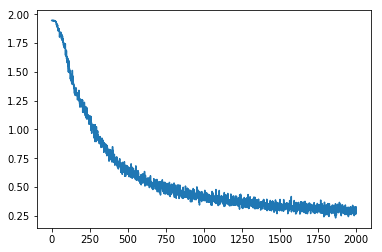

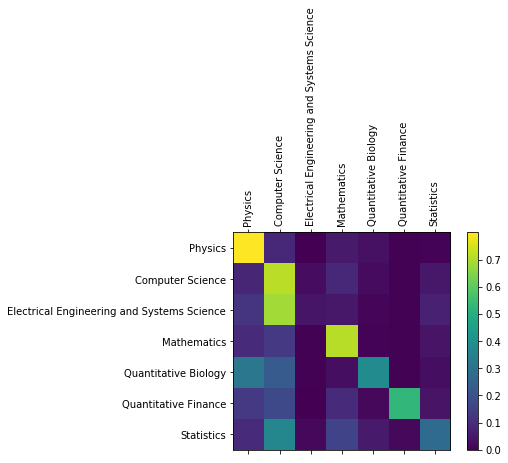

tensor([[79.,  9.,  0.,  5.,  3.,  0.,  0.],
        [ 8., 71.,  2.,  8.,  2.,  0.,  5.],
        [12., 68.,  4.,  5.,  1.,  0.,  7.],
        [ 9., 13.,  0., 71.,  0.,  0.,  4.],
        [31., 22.,  0.,  2., 38.,  0.,  2.],
        [13., 17.,  0.,  9.,  1., 53.,  4.],
        [ 9., 37.,  1., 16.,  5.,  1., 27.]])


In [6]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 270
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 260 characters (70% / 86%)

With regards to abstracts of length at least 260,
	203947 abstracts for Physics
	141798 abstracts for Computer Science
	  6285 abstracts for Electrical Engineering and Systems Science
	142069 abstracts for Mathematics
	 25576 abstracts for Quantitative Biology
	 11615 abstracts for Quantitative Finance
	 21937 abstracts for Statistics
100 0.1% (0.0m 10.467812061309814s) 1.942 / Computer Science X Statistics
200 0.2% (0.0m 20.91559863090515s) 1.957 / Electrical Engineering and Systems Science X Mathematics
300 0.3% (0.0m 31.428824424743652s) 1.949 / Statistics X Quantitative Finance
400 0.4% (0.0m 41.828227281570435s) 1.949 / Statistics X Physics
500 0.5% (0.0m 52.31422567367554s) 1.948 / Quantitative Biology V
600 0.6% (1.0m 2.6423115730285645s) 1.928 / Quantitative Finance X Physics
700 0.7% (1.0m 13.025457382202148s) 1.935 / Mathematics X Electrical Engineering and Systems Science
800 0.8% (1.0m 23.452089071273804s) 1.914 / Electrical Engineering and Systems Science V
900 0.9% (1.0m 

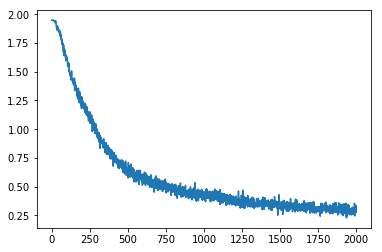

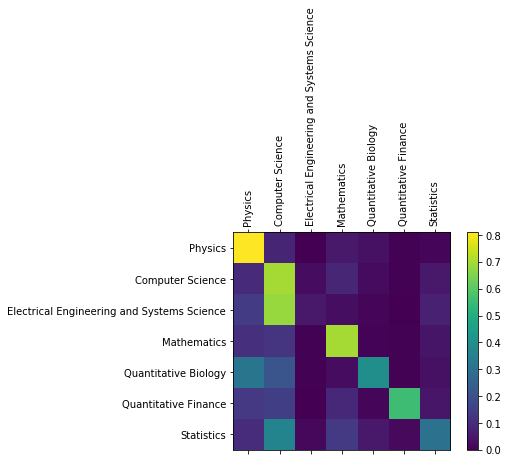

tensor([[80.,  8.,  0.,  5.,  3.,  0.,  1.],
        [ 9., 70.,  2.,  8.,  2.,  0.,  5.],
        [14., 68.,  5.,  3.,  1.,  0.,  7.],
        [11., 12.,  0., 69.,  0.,  0.,  4.],
        [31., 21.,  0.,  2., 39.,  0.,  3.],
        [13., 15.,  0.,  9.,  1., 55.,  4.],
        [10., 36.,  1., 13.,  5.,  1., 30.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 260
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 250 characters (69% / 86%)

With regards to abstracts of length at least 250,
	204182 abstracts for Physics
	141941 abstracts for Computer Science
	  6293 abstracts for Electrical Engineering and Systems Science
	143343 abstracts for Mathematics
	 25594 abstracts for Quantitative Biology
	 11639 abstracts for Quantitative Finance
	 21961 abstracts for Statistics
100 0.1% (0.0m 10.589240789413452s) 1.944 / Electrical Engineering and Systems Science V
200 0.2% (0.0m 21.13837957382202s) 1.968 / Electrical Engineering and Systems Science X Quantitative Finance
300 0.3% (0.0m 31.619400024414062s) 1.935 / Electrical Engineering and Systems Science V
400 0.4% (0.0m 42.13116216659546s) 1.932 / Electrical Engineering and Systems Science X Computer Science
500 0.5% (0.0m 52.749194622039795s) 1.949 / Electrical Engineering and Systems Science X Mathematics
600 0.6% (1.0m 3.177121162414551s) 1.94 / Computer Science X Quantitative Biology
700 0.7% (1.0m 13.561388969421387s) 1.953 / Quantitative Biology X Statistics
800 0.8% (

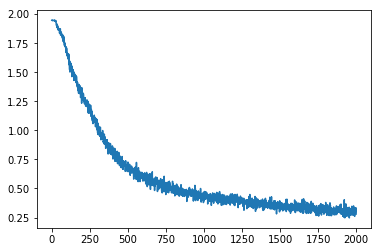

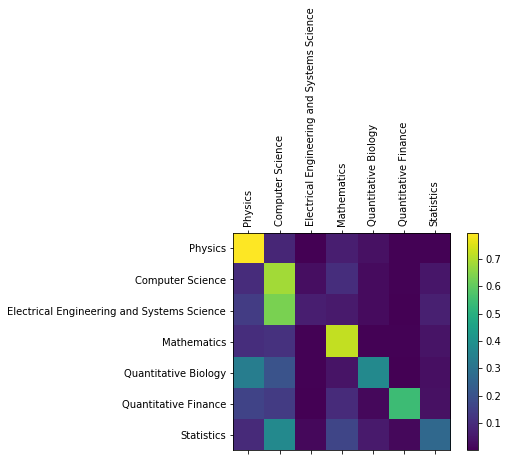

tensor([[79.,  8.,  0.,  6.,  3.,  0.,  0.],
        [10., 68.,  3., 10.,  2.,  0.,  4.],
        [14., 63.,  6.,  5.,  2.,  0.,  7.],
        [10., 11.,  0., 72.,  0.,  0.,  4.],
        [33., 20.,  0.,  4., 37.,  0.,  3.],
        [16., 13.,  0.,  9.,  1., 54.,  3.],
        [ 9., 37.,  1., 16.,  5.,  1., 26.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 250
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 240 characters (69% / 86%)

With regards to abstracts of length at least 240,
	204394 abstracts for Physics
	142064 abstracts for Computer Science
	  6295 abstracts for Electrical Engineering and Systems Science
	144555 abstracts for Mathematics
	 25607 abstracts for Quantitative Biology
	 11658 abstracts for Quantitative Finance
	 21976 abstracts for Statistics
100 0.1% (0.0m 9.604387760162354s) 1.951 / Electrical Engineering and Systems Science V
200 0.2% (0.0m 19.149869680404663s) 1.945 / Electrical Engineering and Systems Science X Quantitative Finance
300 0.3% (0.0m 28.877673625946045s) 1.945 / Computer Science X Physics
400 0.4% (0.0m 38.5826895236969s) 1.944 / Quantitative Biology X Electrical Engineering and Systems Science
500 0.5% (0.0m 48.35643529891968s) 1.94 / Quantitative Finance V
600 0.6% (0.0m 58.16458439826965s) 1.908 / Statistics X Computer Science
700 0.7% (1.0m 7.881966829299927s) 1.946 / Statistics X Computer Science
800 0.8% (1.0m 17.624040365219116s) 1.949 / Computer Science X Quantitative

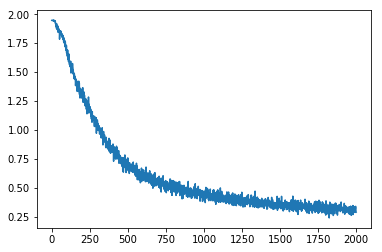

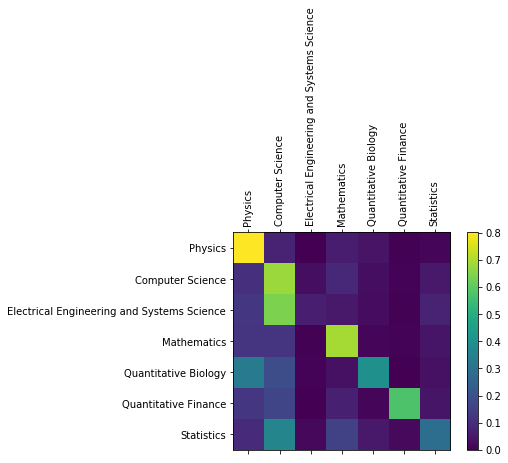

tensor([[80.,  7.,  0.,  6.,  4.,  0.,  0.],
        [10., 68.,  2.,  9.,  2.,  0.,  5.],
        [12., 64.,  6.,  5.,  2.,  0.,  8.],
        [12., 12.,  0., 69.,  0.,  0.,  4.],
        [32., 19.,  0.,  3., 40.,  0.,  3.],
        [12., 16.,  0.,  7.,  1., 57.,  4.],
        [ 9., 36.,  1., 15.,  5.,  2., 28.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 240
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 230 characters (68% / 85%)

With regards to abstracts of length at least 230,
	204630 abstracts for Physics
	142200 abstracts for Computer Science
	  6302 abstracts for Electrical Engineering and Systems Science
	145684 abstracts for Mathematics
	 25616 abstracts for Quantitative Biology
	 11678 abstracts for Quantitative Finance
	 21990 abstracts for Statistics
100 0.1% (0.0m 9.259647130966187s) 1.948 / Computer Science X Electrical Engineering and Systems Science
200 0.2% (0.0m 18.54151701927185s) 1.947 / Physics V
300 0.3% (0.0m 27.803151607513428s) 1.952 / Quantitative Biology X Physics
400 0.4% (0.0m 37.075825929641724s) 1.931 / Statistics X Electrical Engineering and Systems Science
500 0.5% (0.0m 46.37216925621033s) 1.94 / Physics V
600 0.6% (0.0m 55.63616442680359s) 1.925 / Electrical Engineering and Systems Science X Physics
700 0.7% (1.0m 4.900538921356201s) 1.927 / Quantitative Finance V
800 0.8% (1.0m 14.27553653717041s) 1.937 / Mathematics X Electrical Engineering and Systems Science
900 0.9% (1.0m 2

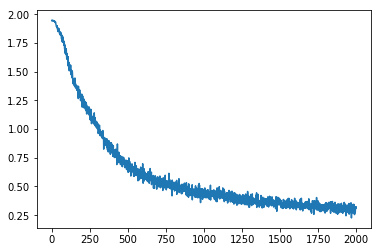

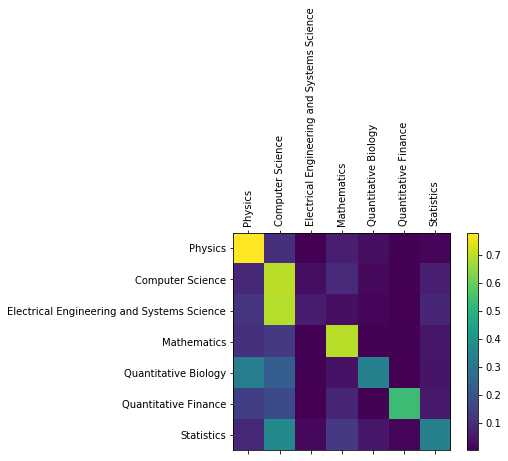

tensor([[77., 10.,  0.,  6.,  3.,  0.,  1.],
        [ 8., 69.,  2.,  9.,  2.,  0.,  6.],
        [11., 69.,  5.,  3.,  1.,  0.,  8.],
        [10., 13.,  0., 69.,  0.,  0.,  4.],
        [33., 23.,  0.,  3., 34.,  0.,  4.],
        [14., 17.,  0.,  8.,  0., 53.,  5.],
        [ 8., 36.,  1., 13.,  4.,  1., 33.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 230
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 220 characters (67% / 84%)

With regards to abstracts of length at least 220,
	204831 abstracts for Physics
	142318 abstracts for Computer Science
	  6306 abstracts for Electrical Engineering and Systems Science
	146720 abstracts for Mathematics
	 25627 abstracts for Quantitative Biology
	 11694 abstracts for Quantitative Finance
	 22000 abstracts for Statistics
100 0.1% (0.0m 8.887146472930908s) 1.946 / Electrical Engineering and Systems Science X Physics
200 0.2% (0.0m 17.88858151435852s) 1.949 / Quantitative Biology X Electrical Engineering and Systems Science
300 0.3% (0.0m 26.821735858917236s) 1.944 / Electrical Engineering and Systems Science X Computer Science
400 0.4% (0.0m 35.64461541175842s) 1.937 / Electrical Engineering and Systems Science X Computer Science
500 0.5% (0.0m 44.461132764816284s) 1.944 / Quantitative Biology V
600 0.6% (0.0m 53.288206577301025s) 1.949 / Electrical Engineering and Systems Science X Mathematics
700 0.7% (1.0m 2.0357327461242676s) 1.938 / Electrical Engineering and Systems 

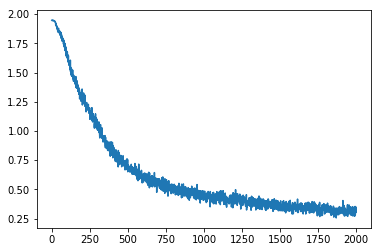

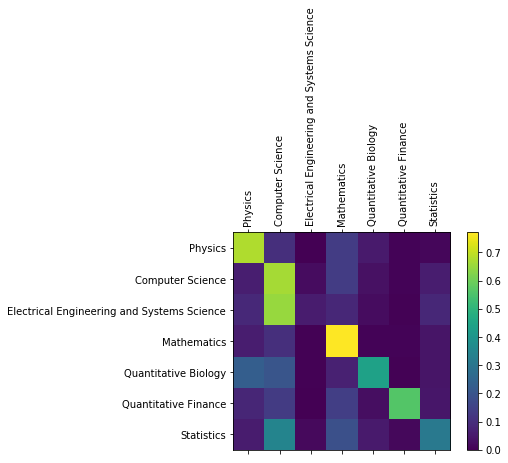

tensor([[67., 10.,  0., 13.,  5.,  0.,  1.],
        [ 6., 66.,  2., 13.,  3.,  0.,  6.],
        [ 9., 65.,  5.,  8.,  2.,  0.,  8.],
        [ 6., 10.,  0., 77.,  0.,  0.,  4.],
        [23., 20.,  0.,  7., 44.,  0.,  4.],
        [ 8., 13.,  0., 14.,  2., 56.,  4.],
        [ 5., 34.,  1., 18.,  5.,  1., 31.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 220
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 210 characters (68% / 85%)

With regards to abstracts of length at least 210,
	205036 abstracts for Physics
	142445 abstracts for Computer Science
	  6308 abstracts for Electrical Engineering and Systems Science
	147763 abstracts for Mathematics
	 25641 abstracts for Quantitative Biology
	 11713 abstracts for Quantitative Finance
	 22016 abstracts for Statistics
100 0.1% (0.0m 8.401556968688965s) 1.946 / Electrical Engineering and Systems Science X Quantitative Finance
200 0.2% (0.0m 16.779909372329712s) 1.949 / Electrical Engineering and Systems Science X Physics
300 0.3% (0.0m 25.140697240829468s) 1.954 / Computer Science X Quantitative Finance
400 0.4% (0.0m 33.46206545829773s) 1.934 / Quantitative Biology X Physics
500 0.5% (0.0m 41.83935189247131s) 1.957 / Quantitative Finance X Quantitative Biology
600 0.6% (0.0m 50.27937841415405s) 1.954 / Statistics X Mathematics
700 0.7% (0.0m 58.65361523628235s) 1.972 / Statistics V
800 0.8% (1.0m 7.003241300582886s) 1.965 / Computer Science X Physics
900 0.9% (1.0m 15.

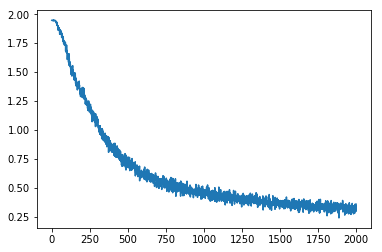

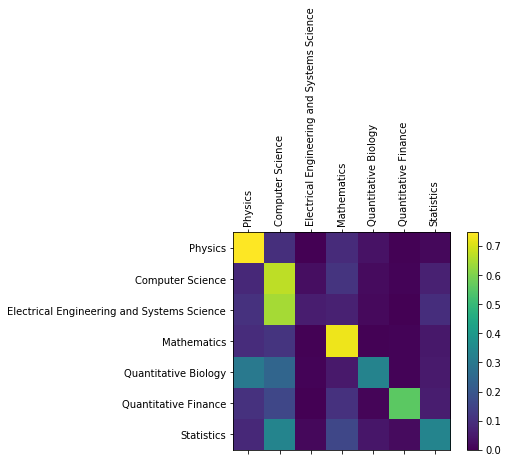

tensor([[74., 10.,  0.,  9.,  3.,  0.,  1.],
        [ 8., 67.,  2., 11.,  2.,  0.,  6.],
        [10., 64.,  6.,  6.,  1.,  0.,  9.],
        [ 9., 11.,  0., 72.,  0.,  0.,  4.],
        [30., 24.,  0.,  5., 33.,  0.,  5.],
        [10., 15.,  0., 10.,  0., 55.,  5.],
        [ 8., 33.,  1., 15.,  4.,  2., 33.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 210
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 200 characters (67% / 84%)

With regards to abstracts of length at least 200,
	205210 abstracts for Physics
	142575 abstracts for Computer Science
	  6312 abstracts for Electrical Engineering and Systems Science
	148798 abstracts for Mathematics
	 25660 abstracts for Quantitative Biology
	 11727 abstracts for Quantitative Finance
	 22026 abstracts for Statistics
100 0.1% (0.0m 8.34512734413147s) 1.938 / Electrical Engineering and Systems Science X Physics
200 0.2% (0.0m 16.554296493530273s) 1.948 / Statistics X Quantitative Biology
300 0.3% (0.0m 24.857800006866455s) 1.948 / Computer Science X Statistics
400 0.4% (0.0m 33.205005168914795s) 1.941 / Quantitative Biology X Physics
500 0.5% (0.0m 41.583035469055176s) 1.928 / Quantitative Finance X Mathematics
600 0.6% (0.0m 49.967217683792114s) 1.963 / Statistics X Quantitative Biology
700 0.7% (0.0m 58.225778579711914s) 1.913 / Quantitative Biology X Statistics
800 0.8% (1.0m 6.447329044342041s) 1.946 / Computer Science X Physics
900 0.9% (1.0m 14.811218500137329s) 

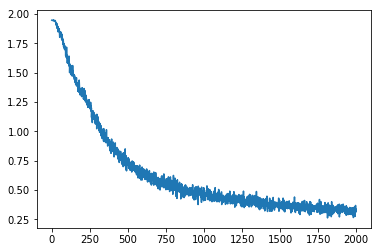

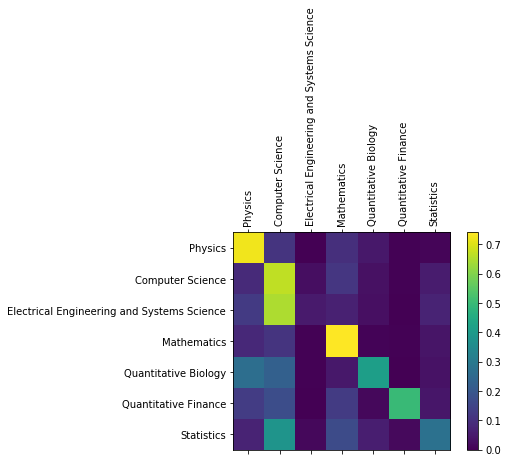

tensor([[72., 11.,  0.,  9.,  4.,  0.,  1.],
        [ 8., 67.,  2., 11.,  3.,  0.,  5.],
        [12., 65.,  5.,  6.,  3.,  0.,  7.],
        [ 8., 11.,  0., 74.,  0.,  0.,  4.],
        [26., 22.,  0.,  4., 41.,  0.,  3.],
        [13., 17.,  0., 12.,  1., 50.,  4.],
        [ 7., 38.,  1., 16.,  6.,  1., 27.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 200
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 190 characters (68% / 85%)

With regards to abstracts of length at least 190,
	205401 abstracts for Physics
	142674 abstracts for Computer Science
	  6312 abstracts for Electrical Engineering and Systems Science
	149721 abstracts for Mathematics
	 25673 abstracts for Quantitative Biology
	 11738 abstracts for Quantitative Finance
	 22032 abstracts for Statistics
100 0.1% (0.0m 7.3215765953063965s) 1.939 / Electrical Engineering and Systems Science X Statistics
200 0.2% (0.0m 14.538639783859253s) 1.943 / Electrical Engineering and Systems Science X Mathematics
300 0.3% (0.0m 21.879541635513306s) 1.947 / Computer Science X Quantitative Finance
400 0.4% (0.0m 29.186065196990967s) 1.95 / Quantitative Biology X Quantitative Finance
500 0.5% (0.0m 36.43456840515137s) 1.92 / Quantitative Finance V
600 0.6% (0.0m 43.73957633972168s) 1.956 / Statistics X Electrical Engineering and Systems Science
700 0.7% (0.0m 50.977360248565674s) 1.942 / Quantitative Biology X Statistics
800 0.8% (0.0m 58.23951697349548s) 1.948 / Comput

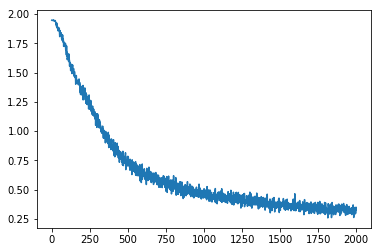

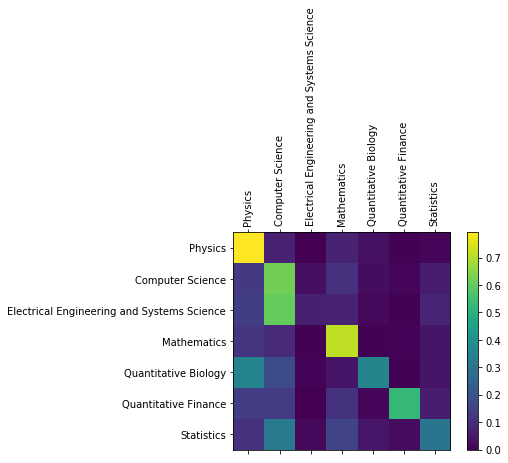

tensor([[79.,  7.,  0.,  7.,  3.,  0.,  1.],
        [13., 62.,  3., 11.,  2.,  1.,  6.],
        [14., 60.,  6.,  7.,  1.,  0.,  8.],
        [12.,  9.,  0., 71.,  0.,  0.,  4.],
        [35., 18.,  0.,  4., 36.,  0.,  4.],
        [14., 13.,  0., 11.,  1., 52.,  5.],
        [11., 33.,  1., 16.,  4.,  2., 30.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 190
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 180 characters (67% / 85%)

With regards to abstracts of length at least 180,
	205550 abstracts for Physics
	142784 abstracts for Computer Science
	  6312 abstracts for Electrical Engineering and Systems Science
	150637 abstracts for Mathematics
	 25685 abstracts for Quantitative Biology
	 11747 abstracts for Quantitative Finance
	 22036 abstracts for Statistics
100 0.1% (0.0m 7.172560453414917s) 1.939 / Physics V
200 0.2% (0.0m 14.263789892196655s) 1.95 / Electrical Engineering and Systems Science X Quantitative Finance
300 0.3% (0.0m 21.368241786956787s) 1.937 / Electrical Engineering and Systems Science X Statistics
400 0.4% (0.0m 28.4837064743042s) 1.96 / Computer Science X Physics
500 0.5% (0.0m 35.619558334350586s) 1.959 / Electrical Engineering and Systems Science X Physics
600 0.6% (0.0m 42.81688380241394s) 1.94 / Computer Science X Quantitative Biology
700 0.7% (0.0m 50.00990653038025s) 1.918 / Electrical Engineering and Systems Science X Quantitative Finance
800 0.8% (0.0m 57.236380100250244s) 1.933 / Q

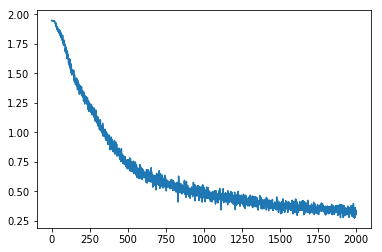

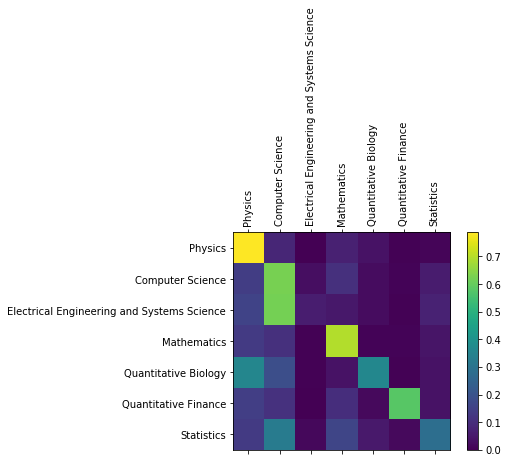

tensor([[78.,  8.,  0.,  7.,  3.,  0.,  1.],
        [14., 62.,  2., 10.,  2.,  0.,  5.],
        [15., 62.,  6.,  5.,  2.,  0.,  7.],
        [13., 10.,  0., 69.,  0.,  0.,  4.],
        [36., 18.,  0.,  3., 36.,  0.,  3.],
        [14., 11.,  0., 10.,  1., 58.,  3.],
        [13., 32.,  1., 16.,  5.,  1., 28.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 180
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 170 characters (67% / 84%)

With regards to abstracts of length at least 170,
	205679 abstracts for Physics
	142872 abstracts for Computer Science
	  6315 abstracts for Electrical Engineering and Systems Science
	151447 abstracts for Mathematics
	 25694 abstracts for Quantitative Biology
	 11751 abstracts for Quantitative Finance
	 22043 abstracts for Statistics
100 0.1% (0.0m 6.837532997131348s) 1.94 / Physics X Mathematics
200 0.2% (0.0m 13.677452325820923s) 1.948 / Quantitative Finance X Statistics
300 0.3% (0.0m 20.500407695770264s) 1.951 / Mathematics X Electrical Engineering and Systems Science
400 0.4% (0.0m 27.261940479278564s) 1.943 / Mathematics V
500 0.5% (0.0m 33.991156816482544s) 1.949 / Electrical Engineering and Systems Science X Mathematics
600 0.6% (0.0m 40.711467266082764s) 1.945 / Electrical Engineering and Systems Science X Quantitative Biology
700 0.7% (0.0m 47.444525718688965s) 1.951 / Electrical Engineering and Systems Science X Computer Science
800 0.8% (0.0m 54.17051887512207s) 1.954 / Co

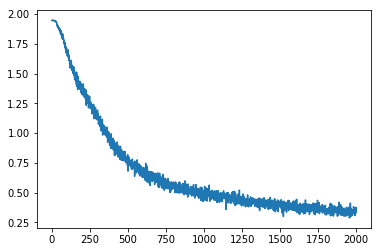

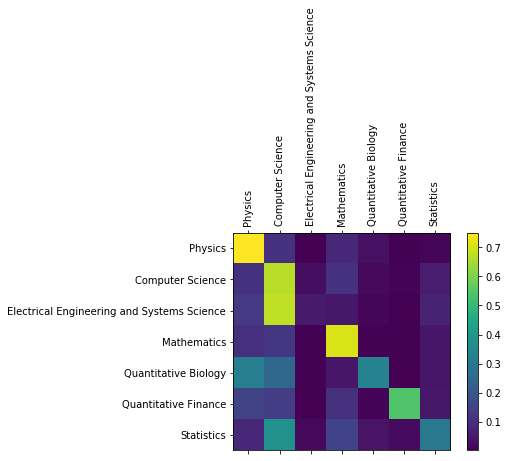

tensor([[75., 10.,  0.,  8.,  3.,  0.,  1.],
        [10., 66.,  2., 10.,  2.,  0.,  5.],
        [12., 67.,  5.,  4.,  1.,  0.,  7.],
        [10., 12.,  0., 70.,  0.,  0.,  4.],
        [32., 25.,  0.,  4., 33.,  0.,  4.],
        [15., 13.,  0., 10.,  0., 54.,  4.],
        [ 8., 37.,  1., 15.,  4.,  2., 30.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 170
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 160 characters (65% / 84%)

With regards to abstracts of length at least 160,
	205805 abstracts for Physics
	142963 abstracts for Computer Science
	  6316 abstracts for Electrical Engineering and Systems Science
	152194 abstracts for Mathematics
	 25700 abstracts for Quantitative Biology
	 11766 abstracts for Quantitative Finance
	 22053 abstracts for Statistics
100 0.1% (0.0m 6.270927429199219s) 1.935 / Electrical Engineering and Systems Science X Quantitative Finance
200 0.2% (0.0m 12.591945886611938s) 1.94 / Electrical Engineering and Systems Science X Quantitative Finance
300 0.3% (0.0m 18.904908895492554s) 1.942 / Quantitative Finance X Electrical Engineering and Systems Science
400 0.4% (0.0m 25.203388690948486s) 1.958 / Statistics X Mathematics
500 0.5% (0.0m 31.53368639945984s) 1.939 / Quantitative Finance V
600 0.6% (0.0m 37.86864471435547s) 1.952 / Computer Science X Electrical Engineering and Systems Science
700 0.7% (0.0m 44.19468927383423s) 1.94 / Physics X Electrical Engineering and Systems Science


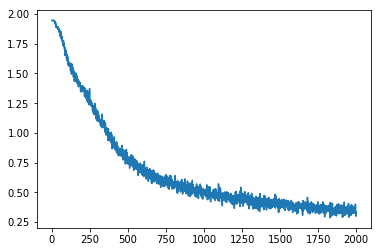

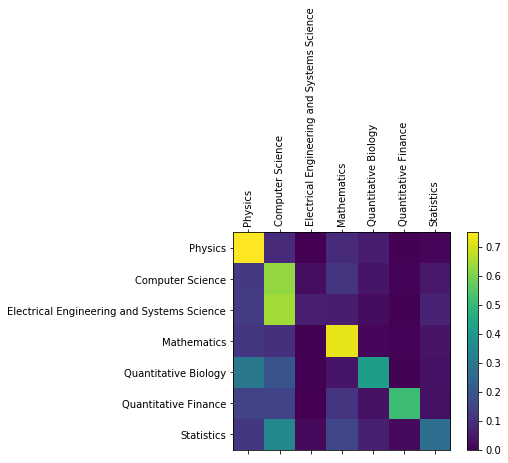

tensor([[74.,  8.,  0.,  8.,  5.,  0.,  0.],
        [12., 62.,  2., 11.,  4.,  0.,  5.],
        [13., 64.,  6.,  5.,  2.,  0.,  7.],
        [11.,  9.,  0., 72.,  1.,  0.,  4.],
        [29., 19.,  0.,  4., 41.,  0.,  3.],
        [15., 14.,  0., 11.,  3., 51.,  3.],
        [12., 34.,  1., 16.,  6.,  1., 26.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 160
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 150 characters (65% / 83%)

With regards to abstracts of length at least 150,
	205938 abstracts for Physics
	143048 abstracts for Computer Science
	  6317 abstracts for Electrical Engineering and Systems Science
	152876 abstracts for Mathematics
	 25709 abstracts for Quantitative Biology
	 11778 abstracts for Quantitative Finance
	 22064 abstracts for Statistics
100 0.1% (0.0m 5.9506754875183105s) 1.935 / Computer Science X Physics
200 0.2% (0.0m 11.900158882141113s) 1.944 / Electrical Engineering and Systems Science X Statistics
300 0.3% (0.0m 17.8543643951416s) 1.948 / Quantitative Finance X Physics
400 0.4% (0.0m 23.785290718078613s) 1.94 / Quantitative Finance V
500 0.5% (0.0m 29.732067584991455s) 1.942 / Computer Science X Quantitative Finance
600 0.6% (0.0m 35.682236194610596s) 1.968 / Statistics X Mathematics
700 0.7% (0.0m 41.610637187957764s) 1.942 / Quantitative Biology V
800 0.8% (0.0m 47.58596110343933s) 1.954 / Statistics X Quantitative Biology
900 0.9% (0.0m 53.55050349235535s) 1.939 / Computer Scie

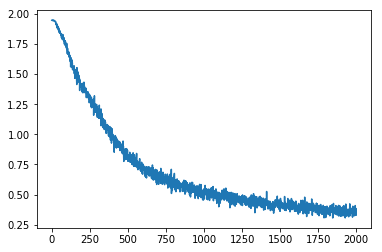

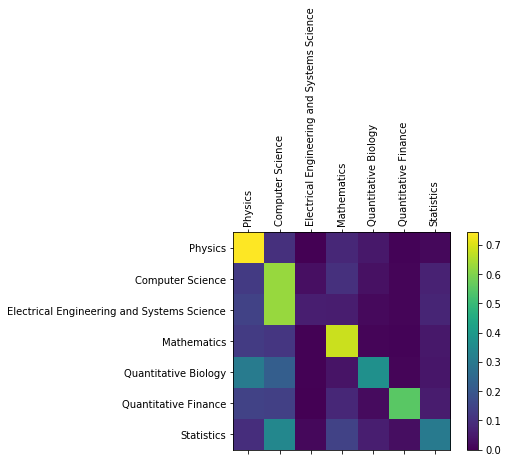

tensor([[74., 10.,  0.,  8.,  4.,  0.,  1.],
        [12., 62.,  3., 10.,  3.,  1.,  7.],
        [14., 62.,  6.,  5.,  1.,  0.,  7.],
        [12., 11.,  0., 68.,  0.,  0.,  4.],
        [30., 22.,  0.,  3., 37.,  0.,  4.],
        [14., 14.,  0.,  8.,  2., 55.,  5.],
        [ 9., 34.,  1., 14.,  6.,  2., 30.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 150
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 140 characters (64% / 82%)

## 130 characters (62% / 81%)


With regards to abstracts of length at least 130,
	206147 abstracts for Physics
	143165 abstracts for Computer Science
	  6320 abstracts for Electrical Engineering and Systems Science
	154158 abstracts for Mathematics
	 25725 abstracts for Quantitative Biology
	 11793 abstracts for Quantitative Finance
	 22078 abstracts for Statistics
100 0.1% (0.0m 5.214782238006592s) 1.954 / Electrical Engineering and Systems Science X Physics
200 0.2% (0.0m 10.384149312973022s) 1.951 / Electrical Engineering and Systems Science X Computer Science
300 0.3% (0.0m 15.72751259803772s) 1.954 / Computer Science X Quantitative Biology
400 0.4% (0.0m 21.05387592315674s) 1.94 / Quantitative Biology X Computer Science
500 0.5% (0.0m 26.27120041847229s) 1.929 / Quantitative Finance V
600 0.6% (0.0m 31.462113857269287s) 1.943 / Statistics X Electrical Engineering and Systems Science
700 0.7% (0.0m 36.72958254814148s) 1.966 / Quantitative Biology V
800 0.8% (0.0m 42.061100482940674s) 1.945 / Mathematics X Physic

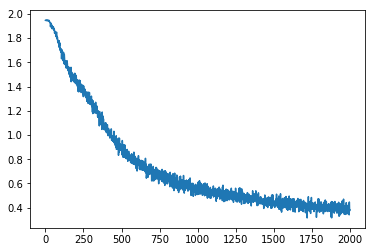

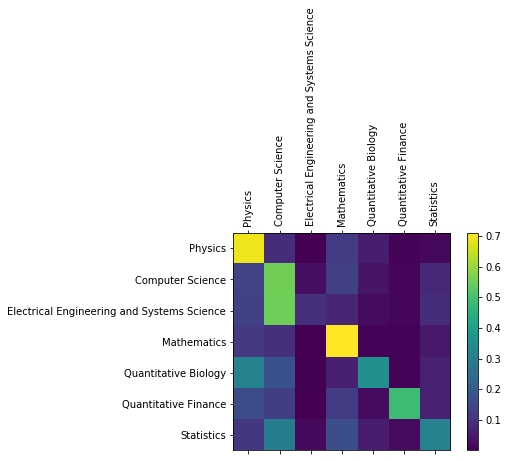

tensor([[69.,  9.,  0., 12.,  5.,  0.,  1.],
        [14., 55.,  3., 13.,  3.,  1.,  8.],
        [13., 55.,  9.,  7.,  2.,  1.,  9.],
        [11.,  9.,  0., 70.,  0.,  0.,  5.],
        [31., 18.,  0.,  6., 35.,  0.,  6.],
        [16., 13.,  0., 12.,  2., 48.,  6.],
        [11., 30.,  1., 17.,  5.,  2., 31.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 130
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 120 characters (61% / 81%)

With regards to abstracts of length at least 120,
	206241 abstracts for Physics
	143230 abstracts for Computer Science
	  6321 abstracts for Electrical Engineering and Systems Science
	154702 abstracts for Mathematics
	 25737 abstracts for Quantitative Biology
	 11799 abstracts for Quantitative Finance
	 22078 abstracts for Statistics
100 0.1% (0.0m 4.391699552536011s) 1.94 / Statistics X Physics
200 0.2% (0.0m 8.74207615852356s) 1.937 / Quantitative Biology X Quantitative Finance
300 0.3% (0.0m 13.0655357837677s) 1.948 / Computer Science V
400 0.4% (0.0m 17.40408682823181s) 1.945 / Quantitative Biology X Mathematics
500 0.5% (0.0m 21.775190353393555s) 1.932 / Physics X Computer Science
600 0.6% (0.0m 26.14574933052063s) 1.945 / Physics X Statistics
700 0.7% (0.0m 30.477446794509888s) 1.938 / Mathematics V
800 0.8% (0.0m 34.81749749183655s) 1.963 / Quantitative Biology X Physics
900 0.9% (0.0m 39.15057444572449s) 1.95 / Electrical Engineering and Systems Science V
1000 1.0% (0.0m 43.49

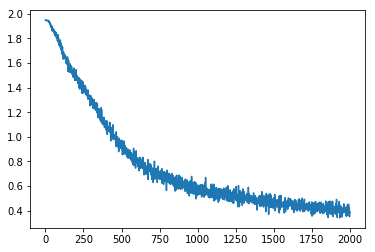

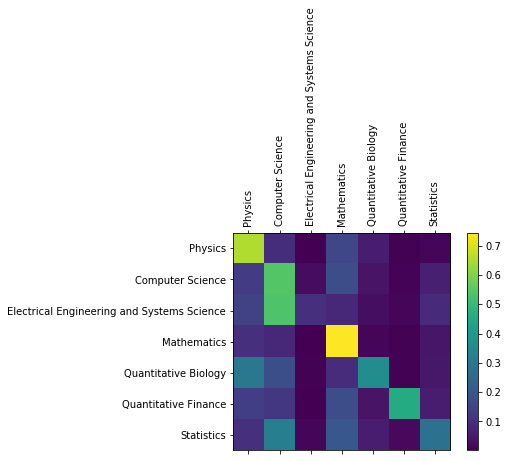

tensor([[65.,  9.,  0., 16.,  6.,  0.,  1.],
        [13., 54.,  2., 17.,  3.,  0.,  6.],
        [14., 53., 10.,  8.,  2.,  1.,  9.],
        [10.,  8.,  0., 74.,  1.,  0.,  4.],
        [29., 17.,  0.,  9., 36.,  0.,  4.],
        [13., 12.,  0., 17.,  4., 45.,  6.],
        [10., 31.,  1., 20.,  6.,  1., 27.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 120
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 110 characters (61% / 81%)

With regards to abstracts of length at least 110,
	206327 abstracts for Physics
	143296 abstracts for Computer Science
	  6322 abstracts for Electrical Engineering and Systems Science
	155165 abstracts for Mathematics
	 25753 abstracts for Quantitative Biology
	 11805 abstracts for Quantitative Finance
	 22080 abstracts for Statistics
100 0.1% (0.0m 4.0432045459747314s) 1.954 / Electrical Engineering and Systems Science X Mathematics
200 0.2% (0.0m 7.959324836730957s) 1.951 / Electrical Engineering and Systems Science X Physics
300 0.3% (0.0m 11.873940229415894s) 1.955 / Computer Science X Mathematics
400 0.4% (0.0m 15.790827512741089s) 1.938 / Quantitative Biology X Electrical Engineering and Systems Science
500 0.5% (0.0m 19.70016312599182s) 1.944 / Quantitative Finance X Electrical Engineering and Systems Science
600 0.6% (0.0m 23.654930591583252s) 1.952 / Statistics X Computer Science
700 0.7% (0.0m 27.609421491622925s) 1.924 / Quantitative Biology X Statistics
800 0.8% (0.0m 31.53

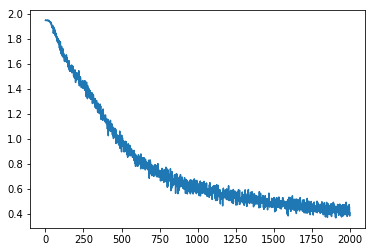

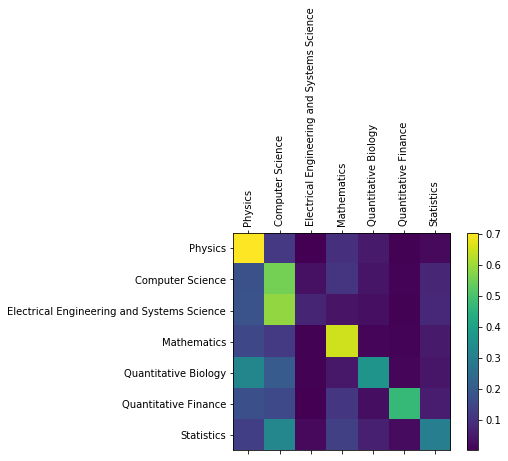

tensor([[70., 11.,  0.,  9.,  5.,  0.,  2.],
        [17., 55.,  3., 10.,  4.,  0.,  7.],
        [18., 58.,  7.,  3.,  3.,  0.,  8.],
        [15., 11.,  0., 65.,  1.,  0.,  5.],
        [32., 20.,  0.,  4., 36.,  1.,  4.],
        [17., 15.,  0., 11.,  2., 47.,  5.],
        [13., 32.,  1., 13.,  6.,  2., 30.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 110
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 100 characters (59% / 80%)

With regards to abstracts of length at least 100,
	206396 abstracts for Physics
	143333 abstracts for Computer Science
	  6323 abstracts for Electrical Engineering and Systems Science
	155544 abstracts for Mathematics
	 25765 abstracts for Quantitative Biology
	 11813 abstracts for Quantitative Finance
	 22084 abstracts for Statistics
100 0.1% (0.0m 3.6220505237579346s) 1.932 / Computer Science X Electrical Engineering and Systems Science
200 0.2% (0.0m 7.217172861099243s) 1.941 / Statistics V
300 0.3% (0.0m 10.803598403930664s) 1.941 / Electrical Engineering and Systems Science X Computer Science
400 0.4% (0.0m 14.403289079666138s) 1.941 / Quantitative Biology V
500 0.5% (0.0m 18.01221251487732s) 1.949 / Quantitative Biology X Quantitative Finance
600 0.6% (0.0m 21.616191148757935s) 1.935 / Physics V
700 0.7% (0.0m 25.19776725769043s) 1.941 / Statistics X Physics
800 0.8% (0.0m 28.799708366394043s) 1.936 / Mathematics X Electrical Engineering and Systems Science
900 0.9% (0.0m 32.3874

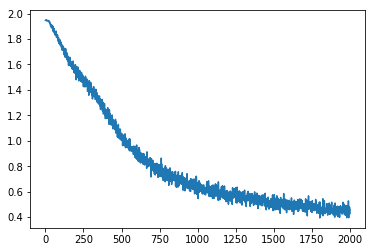

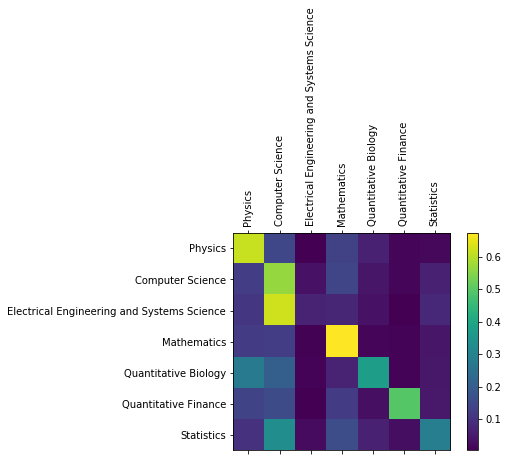

tensor([[61., 14.,  0., 13.,  6.,  1.,  1.],
        [12., 56.,  3., 14.,  4.,  1.,  6.],
        [10., 62.,  6.,  7.,  3.,  0.,  7.],
        [12., 12.,  0., 67.,  1.,  0.,  4.],
        [28., 20.,  0.,  7., 37.,  0.,  4.],
        [13., 15.,  0., 12.,  3., 49.,  4.],
        [ 9., 33.,  2., 16.,  6.,  2., 28.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 100
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 90 characters (57% / 79%)

With regards to abstracts of length at least 90,
	206461 abstracts for Physics
	143395 abstracts for Computer Science
	  6324 abstracts for Electrical Engineering and Systems Science
	155861 abstracts for Mathematics
	 25768 abstracts for Quantitative Biology
	 11815 abstracts for Quantitative Finance
	 22085 abstracts for Statistics
100 0.1% (0.0m 3.3776254653930664s) 1.94 / Electrical Engineering and Systems Science X Physics
200 0.2% (0.0m 6.58229923248291s) 1.953 / Electrical Engineering and Systems Science V
300 0.3% (0.0m 9.809560537338257s) 1.957 / Computer Science X Mathematics
400 0.4% (0.0m 13.021363496780396s) 1.947 / Quantitative Biology V
500 0.5% (0.0m 16.236997365951538s) 1.945 / Quantitative Finance X Electrical Engineering and Systems Science
600 0.6% (0.0m 19.482754945755005s) 1.953 / Statistics X Computer Science
700 0.7% (0.0m 22.722017765045166s) 1.95 / Quantitative Biology X Mathematics
800 0.8% (0.0m 25.95490026473999s) 1.945 / Mathematics X Statistics
900 0.9% (

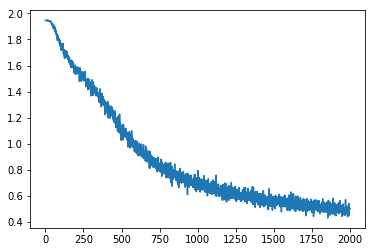

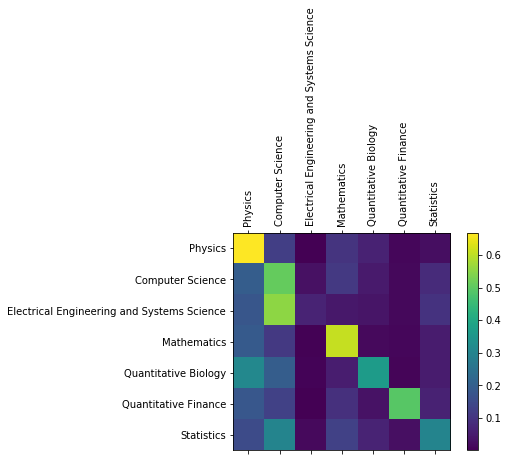

tensor([[66., 12.,  0., 10.,  6.,  1.,  2.],
        [19., 50.,  3., 11.,  4.,  1.,  8.],
        [18., 55.,  6.,  4.,  3.,  1.,  9.],
        [18., 11.,  0., 60.,  1.,  1.,  5.],
        [31., 19.,  0.,  5., 36.,  1.,  5.],
        [18., 13.,  0.,  9.,  3., 49.,  6.],
        [15., 30.,  1., 12.,  6.,  2., 30.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 90
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 80 characters (55% / 77%)

With regards to abstracts of length at least 80,
	206506 abstracts for Physics
	143438 abstracts for Computer Science
	  6324 abstracts for Electrical Engineering and Systems Science
	156092 abstracts for Mathematics
	 25770 abstracts for Quantitative Biology
	 11817 abstracts for Quantitative Finance
	 22091 abstracts for Statistics
100 0.1% (0.0m 3.154444456100464s) 1.951 / Quantitative Finance X Computer Science
200 0.2% (0.0m 6.156294822692871s) 1.962 / Computer Science X Quantitative Biology
300 0.3% (0.0m 9.207870483398438s) 1.944 / Statistics X Computer Science
400 0.4% (0.0m 12.195858001708984s) 1.947 / Electrical Engineering and Systems Science X Statistics
500 0.5% (0.0m 15.142724752426147s) 1.939 / Physics X Quantitative Biology
600 0.6% (0.0m 18.130443811416626s) 1.944 / Quantitative Biology V
700 0.7% (0.0m 21.187846422195435s) 1.938 / Statistics X Electrical Engineering and Systems Science
800 0.8% (0.0m 24.231496572494507s) 1.944 / Physics V
900 0.9% (0.0m 27.24866986274

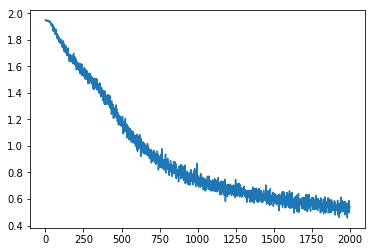

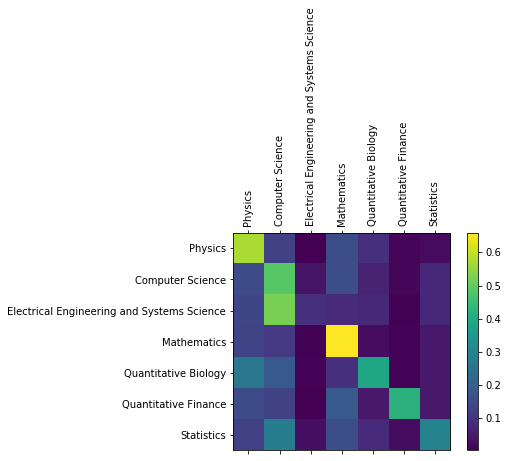

tensor([[57., 13.,  0., 15.,  9.,  1.,  2.],
        [15., 48.,  4., 15.,  6.,  1.,  7.],
        [13., 52.,  9.,  8.,  7.,  0.,  7.],
        [13., 11.,  0., 65.,  2.,  0.,  4.],
        [26., 18.,  0.,  9., 39.,  0.,  4.],
        [15., 13.,  0., 18.,  4., 42.,  4.],
        [12., 27.,  3., 16.,  8.,  2., 29.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 80
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 70 characters (49% / 73%)

With regards to abstracts of length at least 70,
	206558 abstracts for Physics
	143468 abstracts for Computer Science
	  6325 abstracts for Electrical Engineering and Systems Science
	156252 abstracts for Mathematics
	 25773 abstracts for Quantitative Biology
	 11821 abstracts for Quantitative Finance
	 22091 abstracts for Statistics
100 0.1% (0.0m 2.7354331016540527s) 1.948 / Mathematics X Quantitative Biology
200 0.2% (0.0m 5.496828317642212s) 1.948 / Statistics X Computer Science
300 0.3% (0.0m 8.255096197128296s) 1.934 / Statistics X Computer Science
400 0.4% (0.0m 10.993207693099976s) 1.931 / Quantitative Biology X Electrical Engineering and Systems Science
500 0.5% (0.0m 13.735867023468018s) 1.924 / Mathematics X Physics
600 0.6% (0.0m 16.465252161026s) 1.964 / Electrical Engineering and Systems Science X Quantitative Biology
700 0.7% (0.0m 19.15649914741516s) 1.946 / Physics X Quantitative Biology
800 0.8% (0.0m 21.83780574798584s) 1.943 / Mathematics V
900 0.9% (0.0m 24.5202143

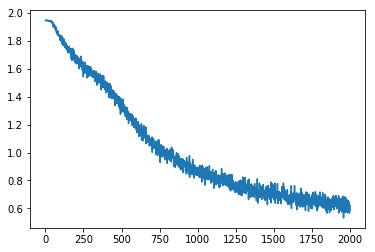

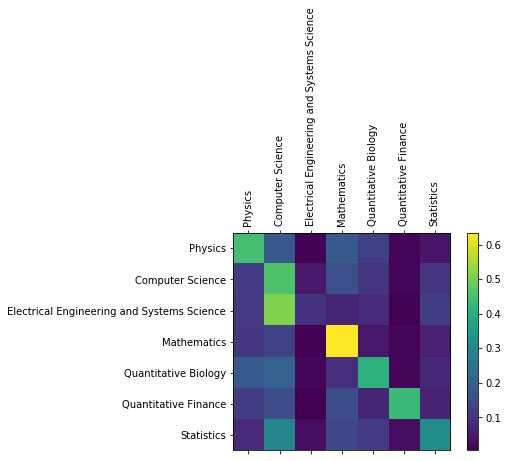

tensor([[44., 18.,  0., 18., 12.,  1.,  4.],
        [11., 45.,  4., 15., 10.,  1., 10.],
        [10., 51.,  9.,  6.,  8.,  0., 12.],
        [10., 12.,  0., 63.,  4.,  1.,  6.],
        [18., 20.,  1.,  9., 41.,  1.,  7.],
        [12., 15.,  0., 15.,  7., 43.,  6.],
        [ 8., 29.,  2., 13., 11.,  2., 31.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 70
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 60 characters (46% / 72%)

With regards to abstracts of length at least 60,
	206582 abstracts for Physics
	143485 abstracts for Computer Science
	  6325 abstracts for Electrical Engineering and Systems Science
	156354 abstracts for Mathematics
	 25777 abstracts for Quantitative Biology
	 11824 abstracts for Quantitative Finance
	 22092 abstracts for Statistics
100 0.1% (0.0m 2.4229276180267334s) 1.95 / Quantitative Biology X Electrical Engineering and Systems Science
200 0.2% (0.0m 4.827884674072266s) 1.943 / Statistics X Mathematics
300 0.3% (0.0m 7.229365110397339s) 1.94 / Quantitative Biology X Physics
400 0.4% (0.0m 9.639637231826782s) 1.948 / Quantitative Finance X Statistics
500 0.5% (0.0m 12.028849840164185s) 1.95 / Statistics X Quantitative Finance
600 0.6% (0.0m 14.412733793258667s) 1.955 / Statistics X Physics
700 0.7% (0.0m 16.817070245742798s) 1.938 / Mathematics X Computer Science
800 0.8% (0.0m 19.236396551132202s) 1.956 / Quantitative Finance X Physics
900 0.9% (0.0m 21.625951290130615s) 1.947 / Q

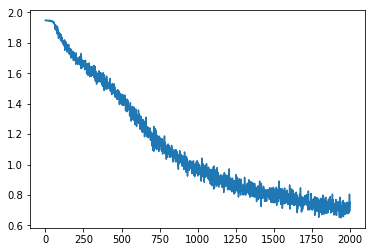

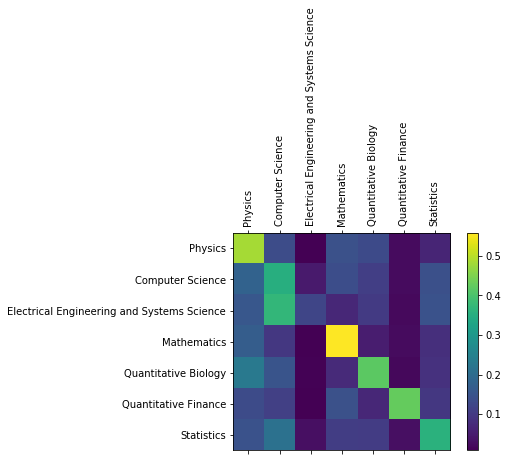

tensor([[48., 13.,  0., 14., 13.,  2.,  6.],
        [18., 35.,  4., 13., 11.,  2., 14.],
        [15., 37., 12.,  6., 10.,  2., 14.],
        [17.,  9.,  1., 55.,  5.,  2.,  8.],
        [23., 15.,  1.,  7., 42.,  2.,  8.],
        [13., 11.,  1., 14.,  7., 42.,  9.],
        [14., 21.,  3., 10., 10.,  3., 35.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 60
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## 50 characters (38% / 65%)

With regards to abstracts of length at least 50,
	206595 abstracts for Physics
	143509 abstracts for Computer Science
	  6325 abstracts for Electrical Engineering and Systems Science
	156413 abstracts for Mathematics
	 25777 abstracts for Quantitative Biology
	 11825 abstracts for Quantitative Finance
	 22095 abstracts for Statistics
100 0.1% (0.0m 2.131895065307617s) 1.939 / Quantitative Finance X Statistics
200 0.2% (0.0m 4.143356084823608s) 1.948 / Statistics X Quantitative Biology
300 0.3% (0.0m 6.153372526168823s) 1.951 / Mathematics X Quantitative Finance
400 0.4% (0.0m 8.157552003860474s) 1.942 / Mathematics X Physics
500 0.5% (0.0m 10.189643621444702s) 1.947 / Mathematics X Computer Science
600 0.6% (0.0m 12.221898794174194s) 1.958 / Quantitative Finance X Statistics
700 0.7% (0.0m 14.237311124801636s) 1.934 / Mathematics X Statistics
800 0.8% (0.0m 16.265038013458252s) 1.951 / Mathematics X Statistics
900 0.9% (0.0m 18.286075353622437s) 1.932 / Electrical Engineering and Syste

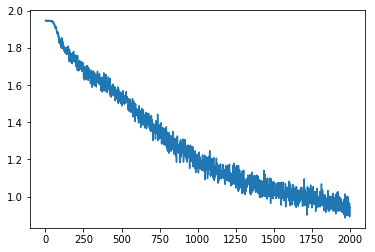

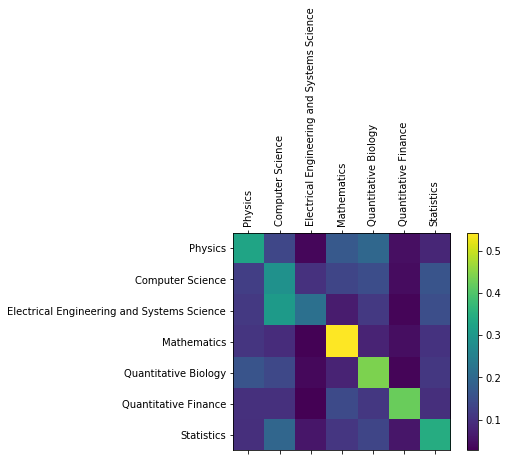

tensor([[32., 13.,  3., 17., 19.,  4.,  8.],
        [12., 28., 10., 13., 14.,  4., 16.],
        [11., 30., 21.,  6., 11.,  3., 15.],
        [10.,  9.,  3., 54.,  7.,  4., 10.],
        [16., 13.,  3.,  7., 44.,  3., 11.],
        [ 9.,  9.,  2., 14., 11., 42.,  9.],
        [ 9., 19.,  5., 10., 13.,  5., 34.]])


In [0]:
learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 50
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)